# Analysis and simulations of evolutionary stable consortia

In [1]:
import numpy as np
import numpy.ma as ma
import scipy.optimize
import matplotlib.pyplot as plt
import math
import sys
from itertools import chain
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm
from scipy.integrate import ode
from statistics import stdev

%matplotlib inline

PIP and stochastic simulation functions adataped from Guilhem Doulcier: https://www.normalesup.org/~doulcier/

## Functions

### Basic model functions

In [2]:
def trait(k):
    return np.log10(k/0.01) / np.log10(100/0.01)

def k(u):
    return 0.01*10**(np.log10(100/0.01)*u)

def mu(u):
    if k(u) < 8.21074:
        return 0.1 * (k(u)/(k(u)+0.0039)) + 0.21 * (k(u)**5.6/(k(u)**5.6+0.023**5.6))
    else:
        return 0.34*k(u)/(0.77 + k(u))
    
mu_vec = np.vectorize(mu)

def y(u):
    if k(u) < 8.21074:
        return 40
    else:
        return 7 * 0.3**10/(0.3**10 + mu(u)**10)

In [3]:
def model(t, model_state, phenotypes):
    s = model_state[0]
    x = np.array(model_state[1:])
    mu_list = np.array([mu(u) for u in phenotypes])
    k_list = np.array([k(u) for u in phenotypes])
    y_list = np.array([y(u) for u in phenotypes])
    
    # the derivatives
    dsdt = sum(-(1/y_list)*(x*mu_list*s/(k_list+s)))
    dxdt = x*mu_list*s/(k_list+s)
    
    return np.append([dsdt], dxdt)

In [4]:
def invasion_fitness(m, r, s0, x0, V=1):
    """Invasion fitness of a rare mutant type with trait m in a resident population with trait r"""
    return math.log(((k(m) + s0)/k(m))**((mu(m)/mu(r))*(k(r) - k(m))/(k(m) + x0/y(r) + s0))*((x0 + y(r)*s0)/x0)**((mu(m)/mu(r))*(k(r)+x0/y(r)+s0)/(k(m)+x0/y(r)+s0)))/math.log((x0 + y(r) * s0)/x0)-1

In [5]:
def invasion_fitness_fast(m, r, s0, x0, sf, V=1):
    """Invasion fitness of a rare mutant type with trait m in a resident population with trait r"""
    return math.log(((k(m) + s0)/(k(m) + s0*sf))**((mu(m)/mu(r))*(k(r) - k(m))/(k(m) + x0/y(r) + s0))*((x0 + y(r)*(s0 - s0*sf))/x0)**((mu(m)/mu(r))*(k(r)+x0/y(r)+s0)/(k(m)+x0/y(r)+s0)))/math.log((x0 + y(r) * (s0 - sf*s0))/x0)-1

In [6]:
def increase_ratio(m, r, s0, x0, V=1):
    """Ratio of x_m_inf/x_m_0 and x_r_inf/x_r_0 of a rare mutant type with trait m in a resident population with trait r"""
    return (((k(m) + s0)/k(m))**((mu(m)/mu(r))*(k(r) - k(m))/(k(m) + x0/y(r) + s0))*((x0 + y(r)*s0)/x0)**((mu(m)/mu(r))*(k(r)+x0/y(r)+s0)/(k(m)+x0/y(r)+s0)))/((x0 + y(r) * s0)/x0)-1

### PIP related functions

In [7]:
def compute_pip(steps, s0, x0, V):
    """Return 3 matrices of size step X step:
    R: Resident population trait (constant on each column, go from 0 to 1 in the first and last column).
    M: Mutant population trait (constant on each line, go from 0 to 1 between the first and last line)
    PIP: Corresponding invasion fitness."""
    
    # Fill the R, M matrices with linearly spaced values in [0, 1]. 
    R,M = np.meshgrid(np.linspace(0,1,steps),
                      np.linspace(0,1,steps))

    s = partial(invasion_fitness, s0=s0, x0=x0, V=V)
    s = np.frompyfunc(s, 2, 1)
    PIP = s(M, R)
    return R, M, PIP

In [8]:
def compute_pip_fast(steps, s0, x0, sf, V=1):
    """Return 3 matrices of size step X step:
    R: Resident population trait (constant on each column, go from 0 to 1 in the first and last column).
    M: Mutant population trait (constant on each line, go from 0 to 1 between the first and last line)
    PIP: Corresponding invasion fitness."""
    
    # Fill the R, M matrices with linearly spaced values in [0, 1]. 
    R,M = np.meshgrid(np.linspace(0,1,steps),
                      np.linspace(0,1,steps))

    s = partial(invasion_fitness_fast, s0=s0, x0=x0,sf=sf, V=V)
    s = np.frompyfunc(s, 2, 1)
    PIP = s(M, R)
    return R, M, PIP

In [9]:
def find_singular_trait_value(p, min, max):
    f = lambda m: invasion_fitness(m,m+1e-5,**p)
    r = scipy.optimize.brentq(f,min,max)
    return r

### Simulating set of differential equations

In [10]:
sol = []
def solout(t, model_state):
        if model_state[0] < 0.001: # perhaps adjust this substrate level, it could be lower
            return -1
        else:
            sol.append([t, *model_state])
            return 0

def serial_transfer(iterations, densities, phenotypes, s0, x0, V):
    timeadd = 0
    global sol
    sol = []
    for i in range(0, iterations):
        #set up model
        r = ode(model)
        r.set_integrator('dopri5') # Integrator that supports solout
        r.set_initial_value(np.insert(densities, 0, s0))
        r.set_f_params(phenotypes)
        r.set_solout(solout)
        r.integrate(1000)
        #adjust the time
        asol = np.array(sol)
        asol[:,0] = asol[:,0] + timeadd
        if i==0:
            totalsol = asol
        else:
            totalsol = np.concatenate((totalsol,asol))
        #reset
        densities = list(sol[-1][2:]/(sum(sol[-1][2:])/x0))
        timeadd += sol[-1][0]
        sol = []
    return totalsol

### Stochastic evolutionary simulations

In [11]:
def popsize(s0, x0, V):
    return x0*V*10**6

In [12]:
def relative_growthrates(state, phenotypes, s0, x0, V=1):
    """Returns the growth rate:
        result is an array of simulations: -1 gives the last iteration of each simulation
        each simulation is an array of timepoints: -1 is the last timepoint,
        every timepoint consists of [time, substrate, x1, x2, ...., xn]"""
    density = (state/sum(state))*x0 # making sure to start with x0
    #print('density is:',density)
    result = serial_transfer(1, density, phenotypes, s0, x0, V)
    #print('result:',result[-1])
    #print('new densities:',x0*result[-1,2:]/sum(result[-1,2:]))
    return ma.log(ma.divide(x0*result[-1,2:]/sum(result[-1,2:]),density)).filled(0)/result[-1,0]

In [13]:
def discrete_bdm_process(T, steps, skip, state,
                         phenotypes, mutation_rate,
                         mutation_effect, get_rates,
                         umin=0, umax=1):
    """ Perform a stochastic simulation of the birth-death process with mutations. 
    
    Args:
        T (int): Final number of iteretions. The process is simulated for T iterations.
        steps (int): number of birth events calculated
        skip (int): only save every `skip` state
        state (np.array of int): the number of individual of each type.
        phenotypes (np.array of floats): the value of the trait of each type.       
        get_rates (function): a functio that maps state,phenotypes to a list of new number of individuals. (ecological model).
        
    Returns:
        trajectory (np.array of int, shape= (len(state), steps)) 
        pheno_traj (np.array of floats, shape= (len(state), steps)) 
        tlist (np.array of floats)
    """
    M = len(state) # number of different phenotypes
    
    # Initialize the data structure for the trajectory 
    trajectory = np.zeros((M,steps//skip+1), dtype=np.int64)
    pheno_traj = np.zeros((M,steps//skip+1))
    trajectory[:,0] = state
    #print('initital trajectory:', trajectory)
    pheno_traj[:,0] = phenotypes
    new_state = np.zeros(M)
    tlist = np.zeros(steps//skip+1)
    dt = T/steps
    print('dt', dt)
    for t in range(1,steps+1):
        # at each time step we compute the new rates
        growth_rate = get_rates(state, phenotypes)
        #print('growth rates:',growth_rate)
        nmutants = np.zeros(M, dtype=int)
        
        # for each type, we compute the new number of individuals, and the number of mutants.
        for i in range(M):        
            if state[i]:
                if state[i] > 1000:
                    new_state[i] = np.int64(round(state[i] * np.exp(growth_rate[i]*dt)))
                    #print('new_state:',new_state[i])
                    nmutants[i] = np.int64(round(new_state[i] * mutation_rate))
                    #print('nmutants:',nmutants[i])
                else:
                    new_state[i] = np.random.poisson(state[i] * np.exp(growth_rate[i]*dt))
                    if new_state[i]:
                        nmutants[i] = np.random.binomial(new_state[i], mutation_rate)
        #print('new_state:',new_state)
        
        # Treat the mutations. 
        if mutation_rate and nmutants.sum(): 
            
            # Create a list that contains the index of the phenotype of 
            # every individual that mutated during the last time interval.
            # i.e. if nmutant = [1,3,2], parent_list = [0,1,1,1,2,2].
            parent_list = list(chain(*[[i]*n for i,n in enumerate(nmutants)]))
            
            # List the empty phenotype slots, this is where we will put the mutants.
            mutants_list = np.arange(M)[state==0]
                        
            # If we have too many potential parents compared to the number of open slots 
            # for phenotype, we select them uniformely at random.
            # Note: this is quite an important restriction of our simulation !
            if len(parent_list) > len(mutants_list):
                parent_list = np.random.choice(parent_list, size=len(mutants_list),replace=False)
                
            # Go through the mutations and do the mutation. 
            for pos_parent, pos_mutant in zip(parent_list, mutants_list):
                phenotypes[pos_mutant] = np.clip(phenotypes[pos_parent] + np.random.normal(0,mutation_effect),umin,umax)
                new_state[pos_mutant] = 1
                new_state[pos_parent] -= 1
        
        #print('new_state (after mutations):',new_state)
        
        # We copy the content of new_state in state. 
        state[:] = new_state[:]
        
        # We save once in a while. 
        if t%skip == 0:
            trajectory[:,t//skip] = state
            #print('trajectory:', trajectory,'state:', state)
            pheno_traj[:,t//skip] = phenotypes
            tlist[t//skip] = t*dt
            sys.stdout.write("\rTimepoint %i of %i" % (t*dt, T))
            sys.stdout.flush()
    return trajectory, pheno_traj, tlist

### Functions for obtaining dominant phenotype(s) from simulations

In [14]:
def dominant_phenotype(state,phenotype_list):
    threshold = max(state)/10000
    state_cut = [i if i > threshold else 0 for i in state]
    local_opt = []
    if state_cut[0] > state_cut[1]:
        local_opt.append(0)
    for i in range(1, len(state_cut)-2):
        if state_cut[i-1]<state_cut[i]>state_cut[i+1]:
            local_opt.append(i)
    if state_cut[-1] > state_cut[-2]:
        local_opt.append(len(state_cut)-1)
    opt_pheno = [phenotype_list[i] for i in local_opt]
    return opt_pheno

In [15]:
def two_phenotypes(dominant_phenotypes, state, phenotype_list):
    # sort the data, for simplicity
    data = sorted(dominant_phenotypes)
    
    if len(data)<2:
        return data
    
    if len(data)==2:
        sd = min(max(.05,np.abs(data[0]-data[1])), .15)
    else:
        # create a list of the gaps between the consecutive values
        gaps = [y - x for x, y in zip(data[:-1], data[1:])]
        # have python calculate the standard deviation for the gaps
        sd = min(max(.05,stdev(gaps)), .15)
        #print(gaps)
    #print(sd)

    # create a list of lists, put the first value of the source data in the first
    lists = [[data[0]]]
    for x in data[1:]:
        # if the gap from the current item to the previous is more than 1 SD
        # Note: the previous item is the last item in the last list
        # Note: the '> 1' is the part you'd modify to make it stricter or more relaxed
        if (x - lists[-1][-1]) / sd > 1:
            # then start a new list
            lists.append([])
        # add the current item to the last list in the list
        lists[-1].append(x)

    #print('lists',lists)
    output_list = []
    for i in lists:
        if len(i)==1:
            output_list.append(i[0])
        else:
            output_list.append(np.average(i, weights=[state[np.where(phenotype_list==j)[0][0]] for j in i]))

    return output_list

## Functions for parameter scans

In [16]:
def coexistence_test(si,xi):
    if (max([invasion_fitness(t,0.43,si,xi) for t in np.linspace(0.7,1)]) > 0):
        if (min([invasion_fitness(0.43,t,si,xi) for t in np.linspace(0.6,1)]) > 0): #check at different level as well
            return 1
        else:
            return -1
    else:
        return -1

### Plotting functions

In [17]:
def display_pip(PIP, R, M, ax=None):
    """Use matplotlib to display the PIP"""
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
    m = ax.contourf(R, M, PIP, 
                levels=[PIP.min(),0,PIP.max()],
                colors=['w','k'])
    ax.set(title='Pairwise invasibility plot', 
       ylabel='Mutant trait m',
       xlabel='resident trait r')

In [18]:
def plot_density(traj, ptraj, tlist, ustep=300, ax=None):
    dist = np.zeros((ustep-1,traj.shape[1]+1))
    bin_min, bin_max = ptraj.min(), ptraj.max()
    bins = np.linspace(bin_min, bin_max, ustep)
        
    for t, traits in enumerate(ptraj.transpose()):
        dist[:,t], _ = np.histogram(traits, weights=traj[:,t], bins=bins)

    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(20,5))
    dmask = dist
    dmask[dmask==0] = np.nan
    mp = ax.imshow(dmask,aspect='auto', 
                   extent=[tlist.min(),tlist.max(),bin_min, bin_max],
                   cmap='viridis',
                   origin='lower')
    ax.set(xlabel='Time',ylabel='Trait')
    cax = make_axes_locatable(ax).append_axes("right", size="1%", pad=0.1)
    ax.get_figure().colorbar(label='density', cax=cax, ax=ax, mappable=mp)

In [19]:
def plot_stack(traj, ptraj, tlist, ax=None, lw=0.3, color_over=100):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(20,5))
    bin_min, bin_max = ptraj.min(), ptraj.max()
    transform = lambda x : (x - bin_min) / (bin_max - bin_min)
    df = np.cumsum(traj,axis=0)
    ax.fill_between(tlist, np.zeros_like(df[0]), df[-1], color='grey')
    for i, (y1, y2) in enumerate(zip(chain([np.zeros_like(df[0]),], df[:-1]), df)):
        bkpts = np.nonzero(ptraj[i,:-1] != ptraj[i,1:])[0]
        for t0,t1 in zip(chain([0,], bkpts), chain(bkpts, [ptraj.shape[1],])):
            t = (t0+t1)//2
            if t0-t1 and np.max(y2[t0:t1]-y1[t0:t1]) > color_over :
                ax.fill_between(tlist[t0:t1],  y1[t0:t1], y2[t0:t1],
                                color=matplotlib.cm.viridis(transform(ptraj[i,t])))
        ax.plot(tlist, y2, color='k', lw=lw)

## General calculation and data

The parameter values used

In [20]:
p = {"s0":500, "x0":1, "V":100}

Load the data of the simulated trajectories

In [21]:
traj1 = np.load('data/traj1_2sp.npy')
ptraj1 = np.load('data/ptraj1_2sp.npy')
tlist1 = np.load('data/tlist1_2sp.npy')

In [22]:
traj2 = np.load('data/traj2_2sp.npy')
ptraj2 = np.load('data/ptraj2_2sp.npy')
tlist2 = np.load('data/tlist2_2sp.npy')

In [23]:
traj3 = np.load('data/traj3_2sp.npy')
ptraj3 = np.load('data/ptraj3_2sp.npy')
tlist3 = np.load('data/tlist3_2sp.npy')

## Create Main Text Figure 5C

Make trajectories from the simulations

In [24]:
traj1_tr = np.transpose(traj1)
traj2_tr = np.transpose(traj2)
traj3_tr = np.transpose(traj3)
ptraj1_tr = np.transpose(ptraj1)
ptraj2_tr = np.transpose(ptraj2)
ptraj3_tr = np.transpose(ptraj3)

In [25]:
phenotype_trajectory1 = [dominant_phenotype(traj1_tr[i],ptraj1_tr[i]) for i in range(0, len(traj1_tr))]
phenotype_trajectory2 = [dominant_phenotype(traj2_tr[i],ptraj2_tr[i]) for i in range(0, len(traj2_tr))]
phenotype_trajectory3 = [dominant_phenotype(traj3_tr[i],ptraj3_tr[i]) for i in range(0, len(traj3_tr))]

In [26]:
two_phenotype_trajectory1 = [two_phenotypes(phenotype_trajectory1[i], traj1_tr[i],ptraj1_tr[i]) for i in range(0, len(traj1_tr))]
two_phenotype_trajectory2 = [two_phenotypes(phenotype_trajectory2[i], traj2_tr[i],ptraj2_tr[i]) for i in range(0, len(traj2_tr))]
two_phenotype_trajectory3 = [two_phenotypes(phenotype_trajectory3[i], traj3_tr[i],ptraj3_tr[i]) for i in range(0, len(traj3_tr))]

In [27]:
phenotype_trajectory_plot1 = np.transpose([[i[0],i[0]] if len(i)==1 else sorted(i) for i in two_phenotype_trajectory1])
phenotype_trajectory_plot2 = np.transpose([[i[0],i[0]] if len(i)==1 else i for i in two_phenotype_trajectory2])
phenotype_trajectory_plot3 = np.transpose([[i[0],i[0]] if len(i)==1 else sorted(i) for i in two_phenotype_trajectory3])

Calculate the pairwise invasibility plot and the singular points

In [28]:
R, M, pip = compute_pip(1000, **p)

In [29]:
rstar = [find_singular_trait_value(p, 0, 0.6), find_singular_trait_value(p, 0.6, 0.8), find_singular_trait_value(p, 0.8, 1)]

Determe the optimal coalition from the trajectory that ends with two phenotypes and determine the invasion fitness of all types in that coalition

In [30]:
optimum_guess = two_phenotype_trajectory3[-1]

In [31]:
pheno_eq = [np.average(ptraj3_tr[-1,ptraj3_tr[-1]>0.6],weights=traj3_tr[-1,ptraj3_tr[-1]>0.6]), np.average(ptraj3_tr[-1,ptraj3_tr[-1]<0.6],weights=traj3_tr[-1,ptraj3_tr[-1]<0.6])]
state_eq = [np.sum(traj3_tr[-1,ptraj3_tr[-1]>0.6]), np.sum(traj3_tr[-1,ptraj3_tr[-1]<0.6])]
print('phenotypes:', pheno_eq, 'densities', state_eq, 'total density', sum(state_eq), 'total density', sum(traj3_tr[-1]), 'fraction first', state_eq[0]/sum(state_eq))

phenotypes: [0.8064103910769718, 0.43720381405072123] densities [16763174, 86578073] total density 103341247 total density 103341247 fraction first 0.16221184170537442


In [32]:
growth_rates_opt = []
for g in np.linspace(0, 1, 1001):
    growth_rates_opt.append(relative_growthrates(state_eq+[1], pheno_eq+[g], **p)[2])

Plot the figure

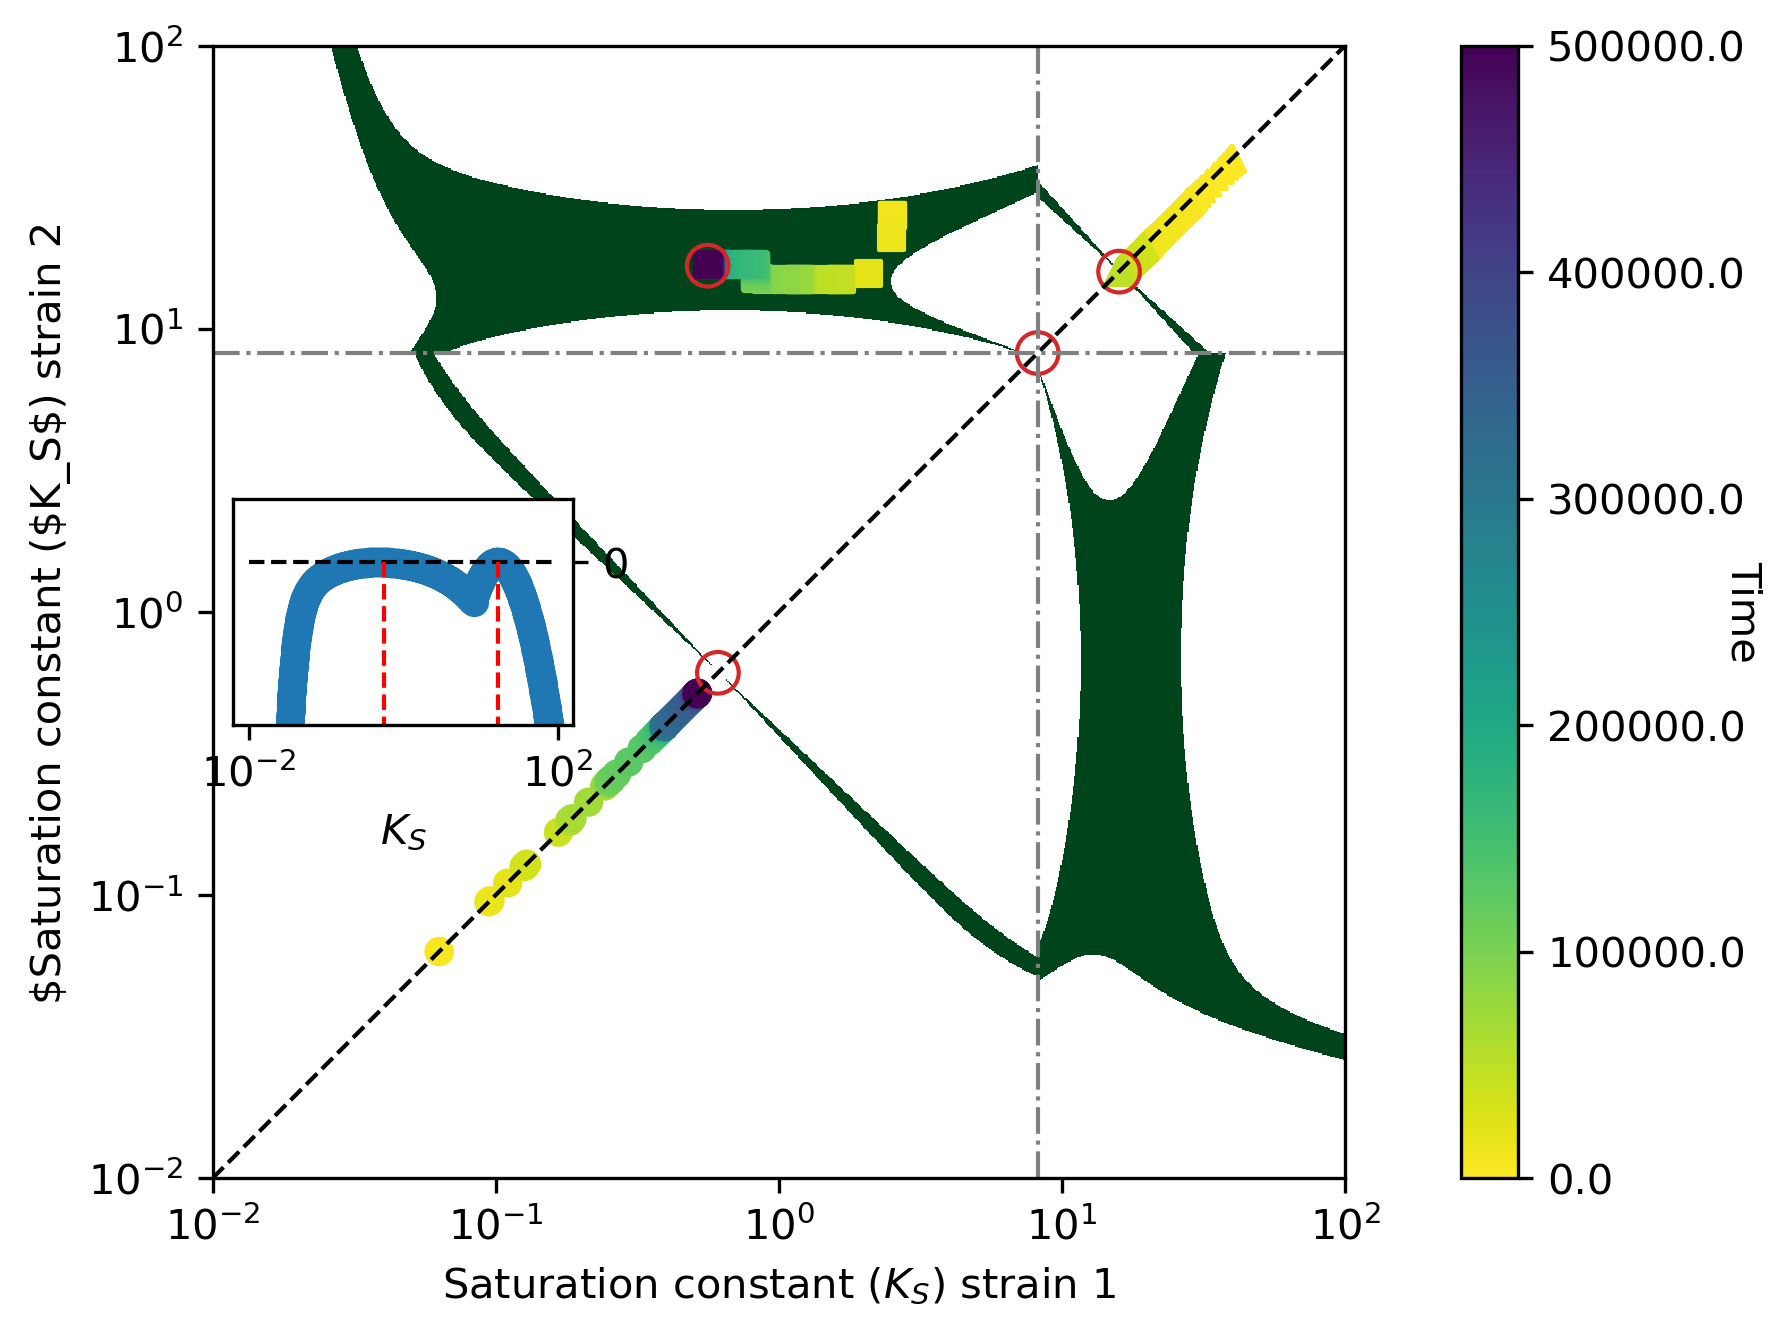

In [46]:
norm = plt.Normalize(0, 500000)

fig,ax = plt.subplots(1,1,figsize=(10,5), dpi=300)

ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=1)

ax.scatter(phenotype_trajectory_plot1[0,0::10], phenotype_trajectory_plot1[1,0::10], c=tlist1[0::10],cmap='viridis_r', norm=norm)
ax.scatter(phenotype_trajectory_plot2[0], phenotype_trajectory_plot2[1], c=tlist2,cmap='viridis_r', marker='^', norm=norm)
cax = ax.scatter(phenotype_trajectory_plot3[0,0::10], phenotype_trajectory_plot3[1,0::10], c=tlist3[0::10],cmap='viridis_r', marker='s', norm=norm)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax,ticks=tlist3[0::200])
cbar.ax.set_yticklabels(tlist3[0::200])
cbar.set_label('Time',rotation=270)

ax.scatter(rstar[0],rstar[0],facecolors='none',color='C3',s=100)
ax.scatter(rstar[1],rstar[1],facecolors='none',color='C3',s=100)
ax.scatter(rstar[2],rstar[2],facecolors='none',color='C3',s=100)
ax.scatter(0.43720381405072123, 0.8057105072206822,facecolors='none',color='C3',s=100)
ax.axvline(x=rstar[1], color='gray', ls='-.', lw='1')
ax.axhline(y=rstar[1], color='gray', ls='-.', lw='1')
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_xticklabels([r'$10^{-2}$', r'$10^{-1}$',r'$10^0$', r'$10^{1}$', r'$10^{2}$'])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([r'$10^{-2}$', r'$10^{-1}$',r'$10^0$', r'$10^{1}$', r'$10^{2}$'])

tep = np.logical_and(np.transpose(pip)>0,pip>0)
tep = np.ma.masked_where(tep == 0, tep)
tep[0,0]=0
ax.imshow(tep, cmap='Greens',
             origin='lower', 
             interpolation='none',
             extent=[0,1,0,1])

ax.set(xlabel=r'Saturation constant ($K_S$) strain 1', ylabel=r'$Saturation constant ($K_S$) strain 2')

axinset = inset_axes(ax, width="30%", height="20%", loc="center left")
axinset.plot([0,1], [0,0], color='k', linestyle='--', linewidth=1)
axinset.plot([optimum_guess[0], optimum_guess[0]], [0,-0.1], color='r', linestyle='--', linewidth=1)
axinset.plot([optimum_guess[1], optimum_guess[1]], [0,-0.1], color='r', linestyle='--', linewidth=1)
axinset.scatter(np.linspace(0, 1, 1001), growth_rates_opt)
axinset.set_ylim(bottom=-0.03)
axinset.set_xticks([0,1])
axinset.set_xticklabels([r'$10^{-2}$', r'$10^{2}$'])
axinset.set(xlabel=r'$K_S$')
axinset.yaxis.set_ticks_position("right")
axinset.yaxis.set_ticks([0])

#plt.savefig('figures/TEP.svg')

## Create Appendix Figure A.13

In [35]:
R, M, PIP = compute_pip(100, **p)
substrate_scan = [{"s0":s, "x0":1, "V":100} for s in np.linspace(300, 700, 9)]
biomass_scan = [{"s0":600, "x0":i, "V":100} for i in np.geomspace(.01,10,9)]
fast_scan =  [{"s0":500, "x0":1, "sf": f, "V":100} for f in np.linspace(0,.05,9)]
pips_substrate_scan =  [compute_pip(100, **p)[2] for p in substrate_scan]
pips_biomass_scan =  [compute_pip(100, **p)[2] for p in biomass_scan]
pips_fast_scan = [compute_pip_fast(100, **p)[2] for p in fast_scan]

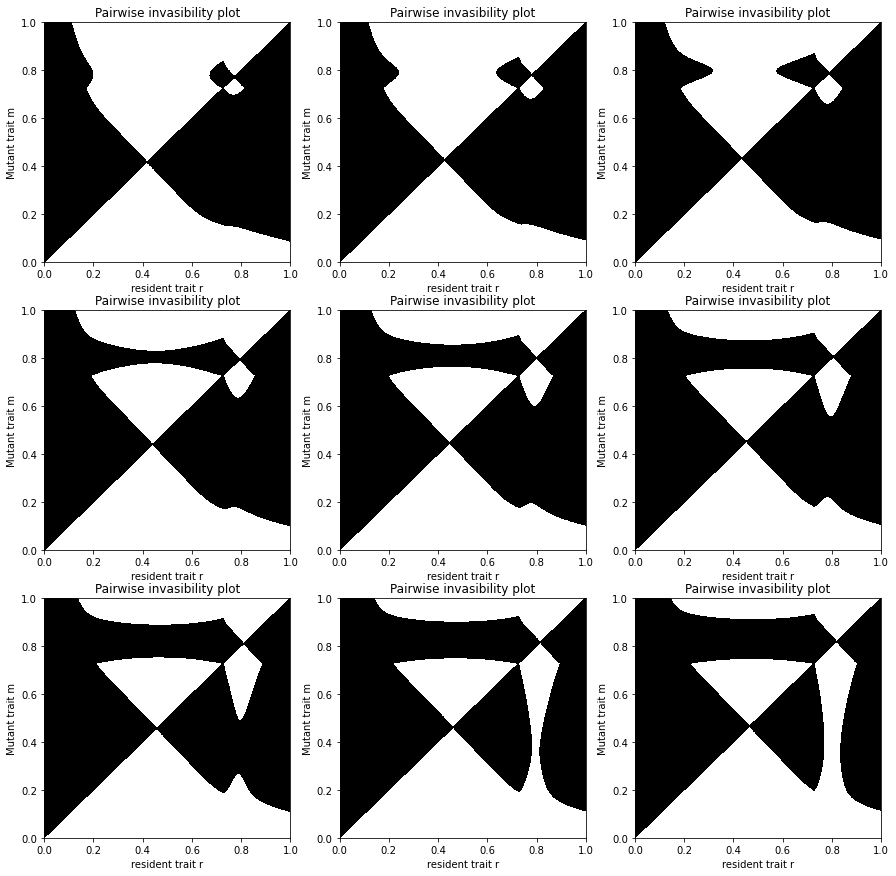

In [38]:
rows = math.ceil(len(pips_substrate_scan)/3)

fig,ax = plt.subplots(rows,3, figsize=(15,5*rows))

for i in range(len(pips_substrate_scan)):
    display_pip(pips_substrate_scan[i], R, M, ax[i//3,i%3])


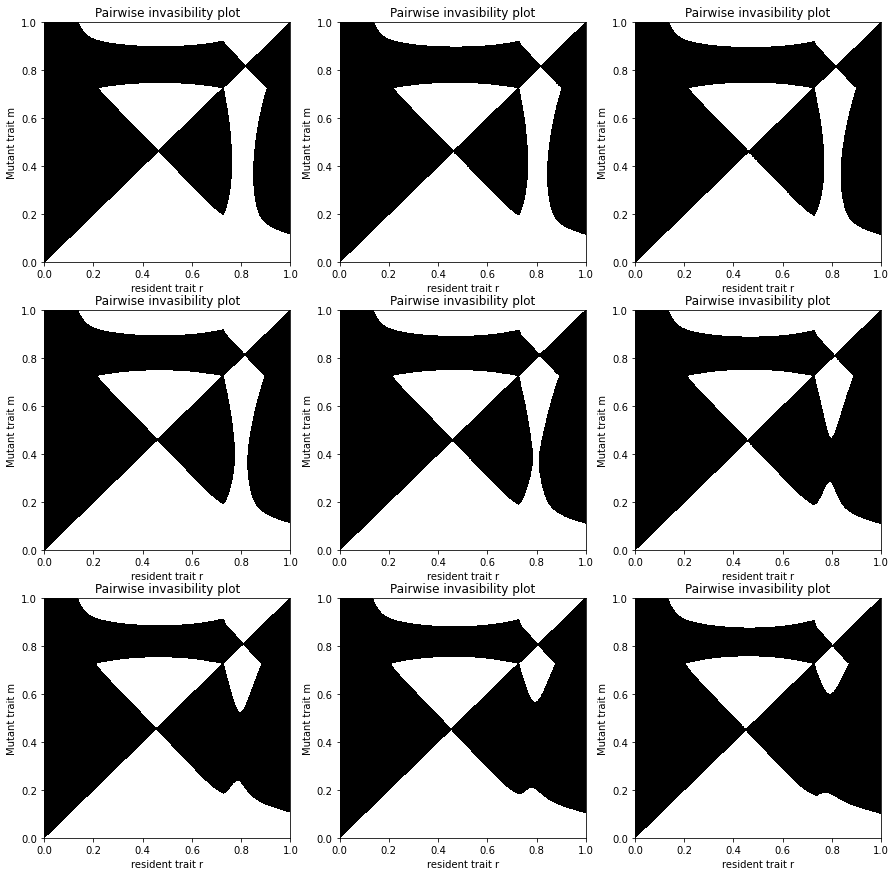

In [39]:
rows = math.ceil(len(pips_biomass_scan)/3)

fig,ax = plt.subplots(rows,3, figsize=(15,5*rows))

for i in range(len(pips_biomass_scan)):
    display_pip(pips_biomass_scan[i], R, M, ax[i//3,i%3])

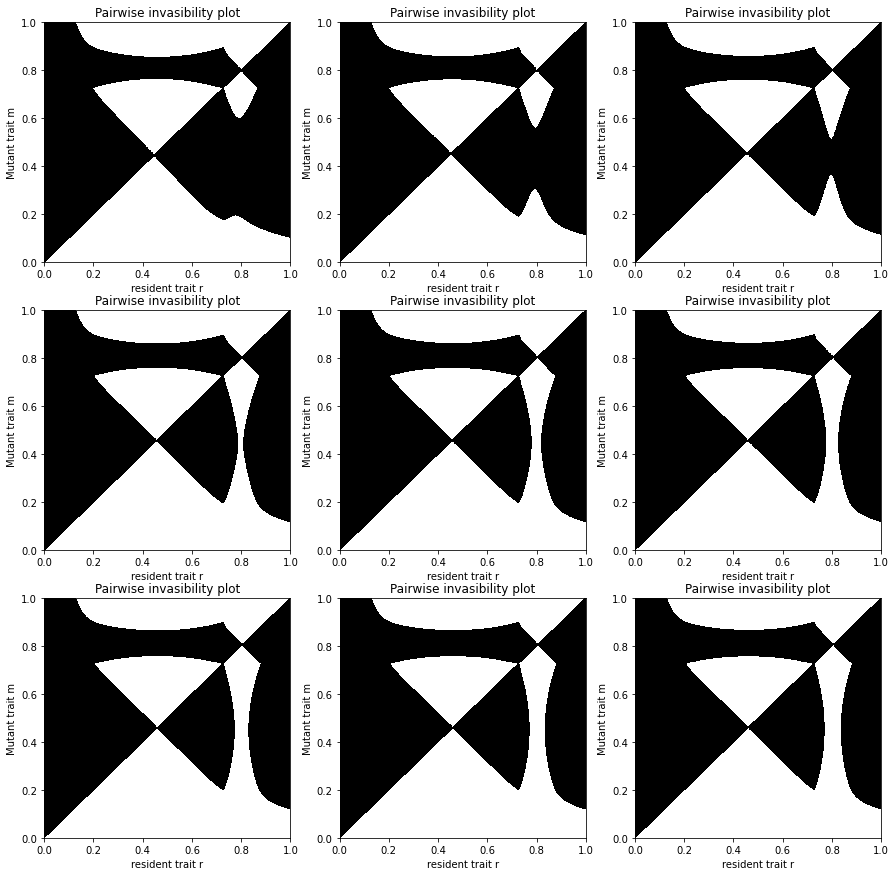

In [40]:
rows = math.ceil(len(pips_fast_scan)/3)

fig,ax = plt.subplots(rows,3, figsize=(15,5*rows))

for i in range(len(pips_fast_scan)):
    display_pip(pips_fast_scan[i], R, M, ax[i//3,i%3])

In [41]:
steps = 1000

si,xi = np.meshgrid(np.linspace(300, 800, steps),
                      np.geomspace(.01,10,steps))
coex_test = np.frompyfunc(coexistence_test, 2, 1)
#uncomment the next line to recalculate the coexistence area
#coex = coex_test(si,xi)

In [42]:
#np.save('data/coex.npy', coex)

In [43]:
coex = np.load('data/coex.npy', allow_pickle=True)

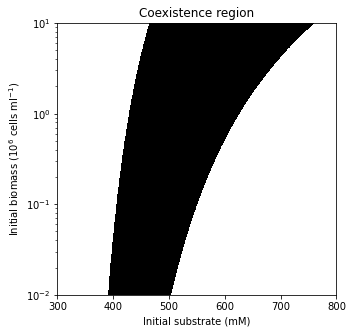

In [44]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.contourf(si, xi, coex, levels=[-1,0,1],colors=['w','k'])
ax.set(title='Coexistence region', xlabel='Initial substrate (mM)',ylabel=r'Initial biomass (10$^6$ cells ml$^{-1}$)')
ax.set_yscale('log')
#plt.savefig('figures/coexistence_area.png')

## Create Appendix Figure A.14

This code is only for rerunning the simulations, the figures can also be plotted with the data that is loaded.

In [ ]:
M = 30 #There can be M+1 phenotypes at any time
# T/steps should be at least 10 (probably more)
traj1, ptraj1, tlist1 = discrete_bdm_process(T=500000, 
                                           steps=10000, # how many stepts (T/steps = dt)
                                           skip=10, # every how many steps to save
                                           state=np.array([popsize(**p)]+[0]*M, dtype=np.int64), 
                                           phenotypes=np.array([0.2]*(M+1)),
                                           mutation_rate=0.0001, #I think it should be low with this high pop sizes
                                           mutation_effect=0.02,
                                           get_rates=partial(relative_growthrates, **p))

In [ ]:
M = 50 #There can be M+1 phenotypes at any time
# T/steps should be at least 10 (probably more)
traj2, ptraj2, tlist2 = discrete_bdm_process(T=50000, 
                                           steps=5000, # how many stepts (T/steps = dt)
                                           skip=10, # every how many steps to save
                                           state=np.array([popsize(**p)]+[0]*M, dtype=np.int64), 
                                           phenotypes=np.array([0.9]*(M+1)),
                                           mutation_rate=0.001, #I think it should be low with this high pop sizes
                                           mutation_effect=0.02,
                                           get_rates=partial(relative_growthrates, **p))

In [ ]:
M = 50 #There can be M+1 phenotypes at any time
# T/steps should be at least 10 (probably more)
traj3, ptraj3, tlist3 = discrete_bdm_process(T=500000, 
                                           steps=10000, # how many stepts (T/steps = dt)
                                           skip=10, # every how many steps to save
                                           state=np.array([popsize(**p)/2]+[0]*(M//2)+[popsize(**p)/2]+[0]*(M//2-1), dtype=np.int64), 
                                           phenotypes=np.array([0.6]*(M//2+1)+[0.85]*(M//2)),
                                           mutation_rate=0.001, #I think it should be low with this high pop sizes
                                           mutation_effect=0.02,
                                           get_rates=partial(relative_growthrates, **p))

Plotting of the figures

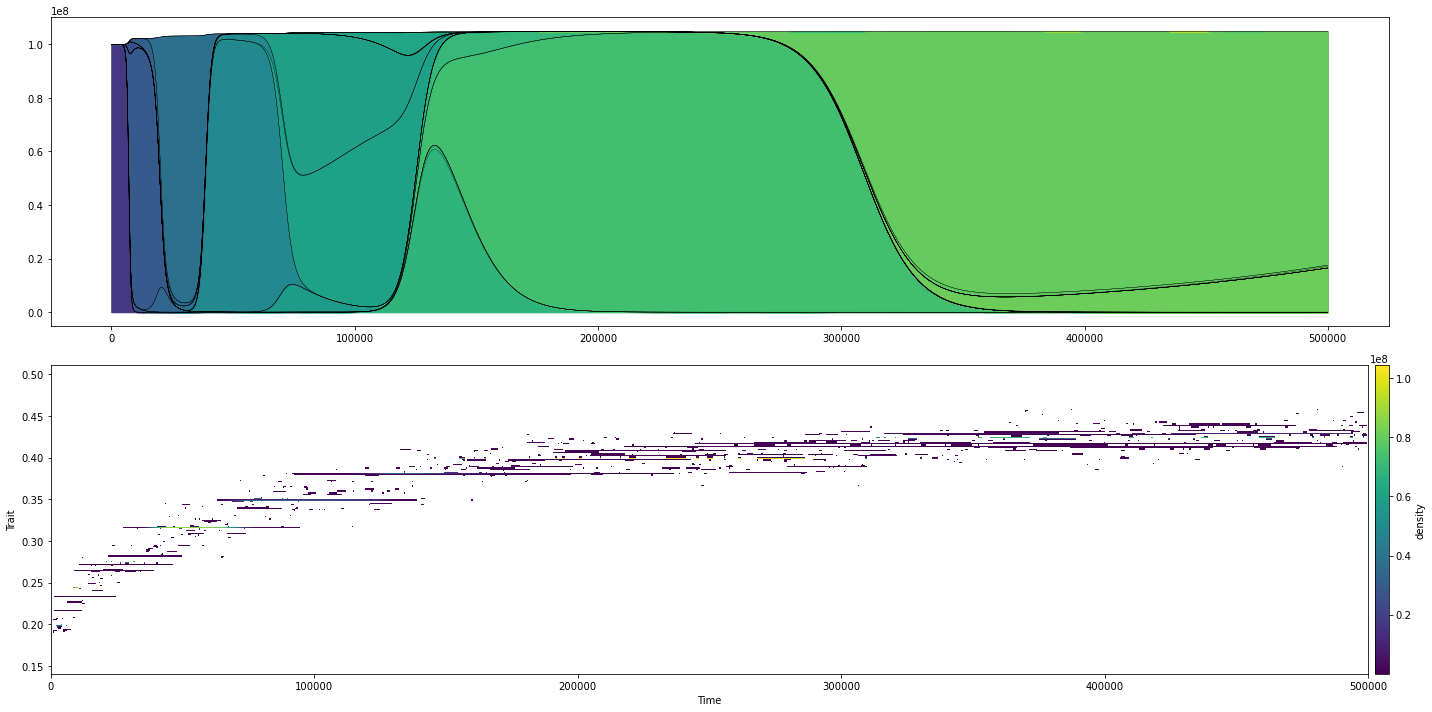

In [49]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,10))
plot_stack(traj1,ptraj1, tlist1,ax=ax1)
plot_density(traj1, ptraj1, tlist1,ax=ax2)
plt.tight_layout()
#plt.savefig('figures/trajectory1.png')

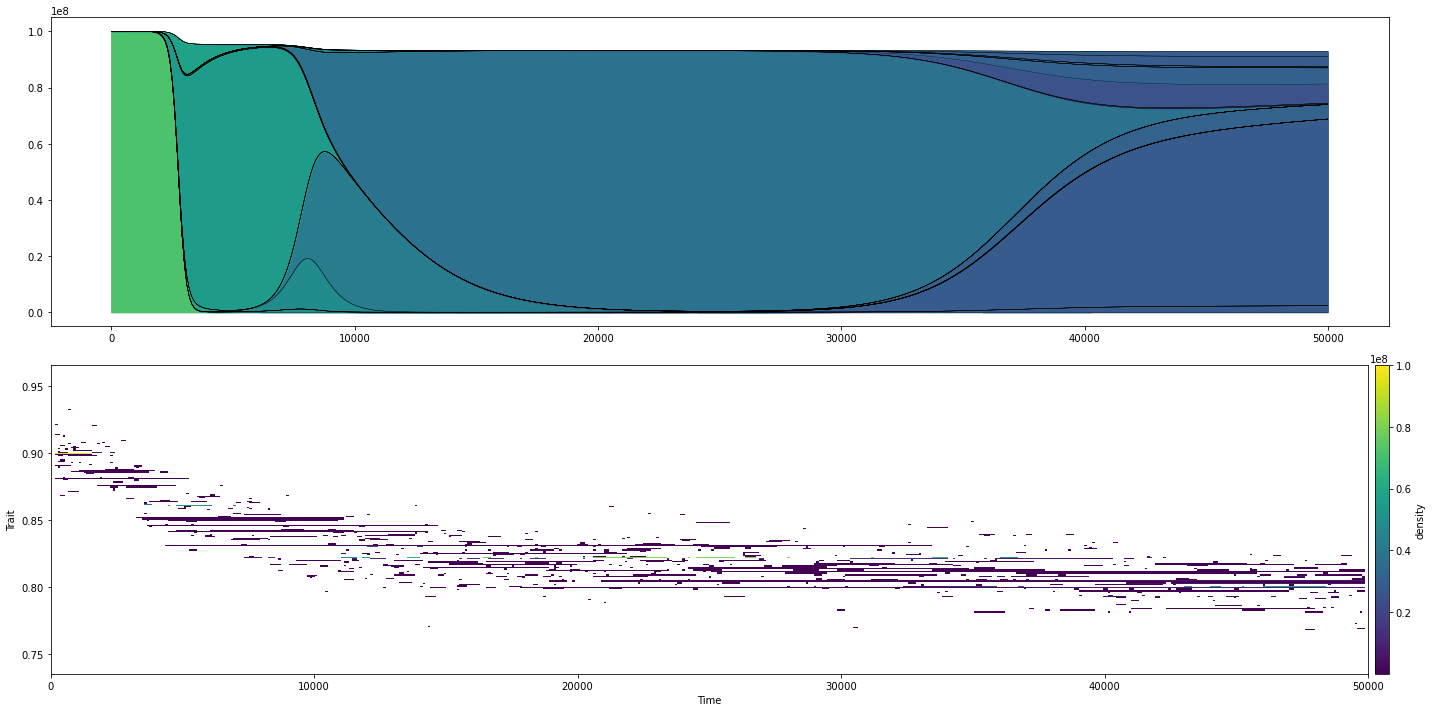

In [50]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,10))
plot_stack(traj2,ptraj2, tlist2,ax=ax1)
plot_density(traj2, ptraj2, tlist2,ax=ax2)
plt.tight_layout()
#plt.savefig('figures/trajectory2.png')

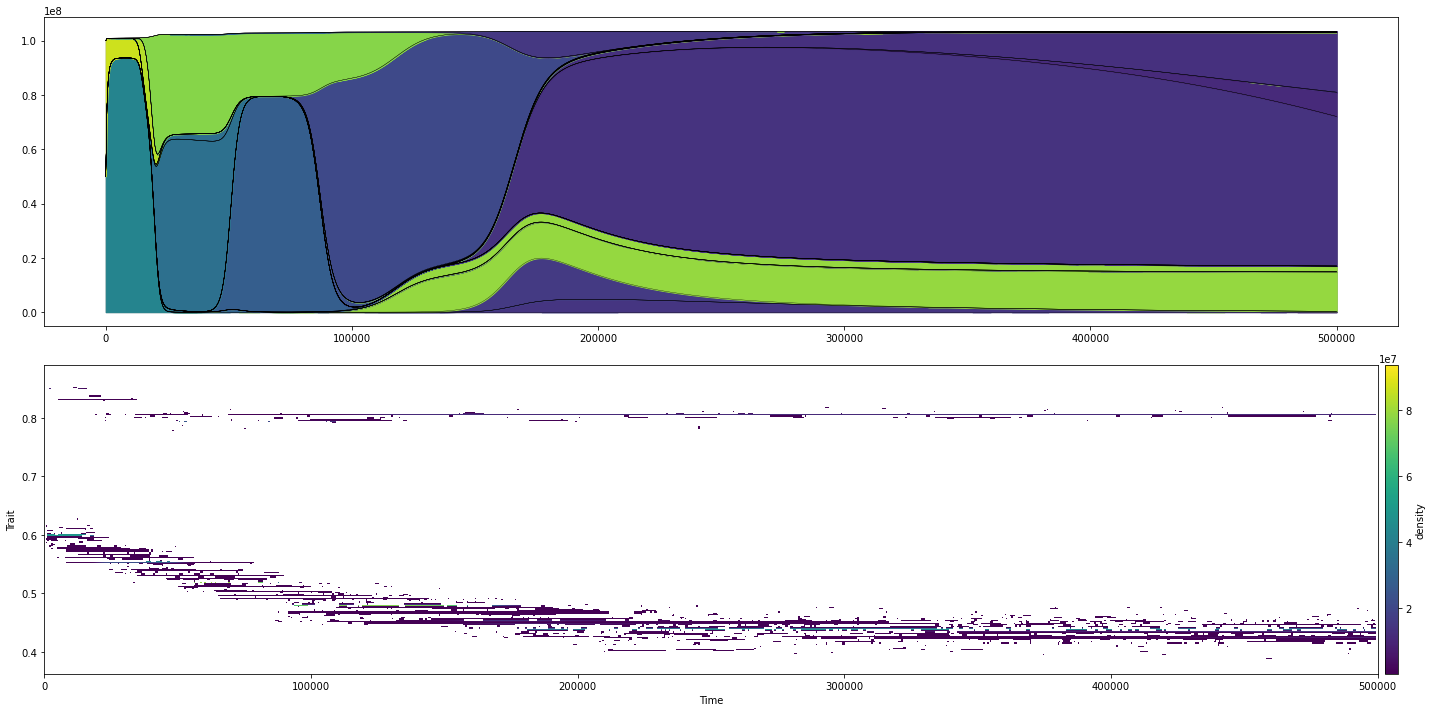

In [51]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,10))
plot_stack(traj3,ptraj3, tlist3,ax=ax1)
plot_density(traj3, ptraj3, tlist3,ax=ax2)
plt.tight_layout()
#plt.savefig('figures/trajectory3.png')

## Create Appendix Figure A.15

(0.39, 0.89)

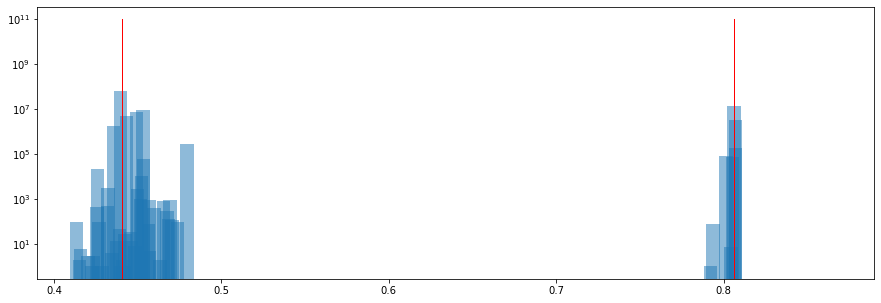

In [52]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.bar(ptraj3_tr[400], traj3_tr[400], width = 0.008, alpha=0.5)
ax.bar(two_phenotype_trajectory3[400], [10**11, 10**11], color='r', width=0.001)
ax.set_yscale('log')
ax.set_xlim(0.39, 0.89)
#plt.savefig('figures/reducingTraits2.png')

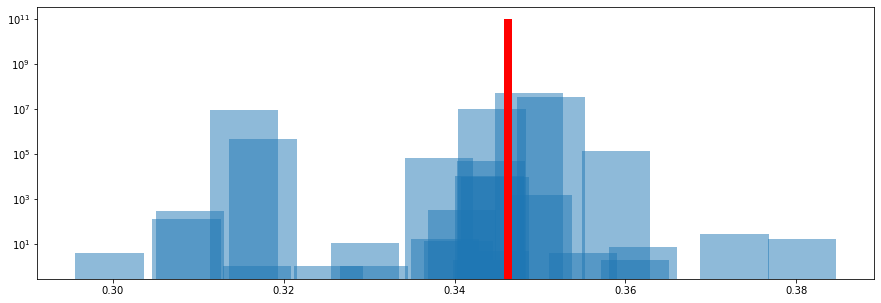

In [53]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.bar(ptraj1_tr[150], traj1_tr[150], width = 0.008, alpha=0.5)
ax.bar(two_phenotype_trajectory1[150], [10**11, 10**11], color='r', width=0.001)
ax.set_yscale('log')
#plt.savefig('figures/reducingTraits1.png')